## Criando uma PINN para a Equação do Calor 1D

Este guia detalha o procedimento para criar uma **PINN (Physics-Informed Neural Network)** com TensorFlow e Keras. O objetivo é resolver a equação de calor 1D transiente, utilizando dados de treinamento existentes para guiar a solução.

A abordagem combina o aprendizado supervisionado tradicional com a imposição de uma restrição física (a própria equação diferencial parcial), permitindo que a rede neural aprenda a solução do problema em todo o domínio espaço-tempo.

### A Equação do Calor 1D Transiente

A equação governante do fenômeno é:

$$ \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} $$

Onde:
- $T$ é a temperatura.
- $t$ é o tempo.
- $x$ é a posição.
- $\alpha$ é a difusividade térmica do material (uma constante).

A rede neural será treinada para aproximar a função $T(x, t)$. A função de perda total será uma combinação de:

1.  **Perda de Dados (MSE):** O erro entre a previsão da rede e os dados de medição fornecidos.
2.  **Perda da Física (Residual da PDE):** Uma medida de quanto a saída da rede viola a equação do calor.

### Resumo do Procedimento

1.  **Carregar e Preparar Dados**: Carregue seu `df` e crie tensores para as posições `(x, t)` e temperaturas `T`.
2.  **Gerar Pontos de Colocação**: Crie um conjunto de pontos `(x, t)` aleatórios dentro do seu domínio para avaliar a perda da física.
3.  **Definir o Modelo**: Crie uma rede neural sequencial com Keras que mapeia `(x, t)` para `T`.
4.  **Implementar as Funções de Perda**:
    - `data_loss`: MSE entre as previsões e os dados reais.
    - `physics_loss`: MSE do residual da PDE, calculado usando `tf.GradientTape` para obter as derivadas.
5.  **Criar o Loop de Treinamento**:
    - Em cada época, calcule a perda de dados e a perda da física.
    - Some-as para obter a perda total.
    - Use `tf.GradientTape` para encontrar os gradientes da perda total em relação aos pesos do modelo.
    - Aplique esses gradientes usando um otimizador como o Adam.
6.  **Treinar e Avaliar**: Execute o loop por um número suficiente de épocas e, ao final, use o `pinn_model` treinado para fazer previsões e visualizar a solução.

### Importação de Bibliotecas

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Preparação dos Dados

Inicialmente, preparamos os tensores de entrada a partir de um DataFrame. Além dos dados de treinamento, geramos "pontos de colocação", isto é, pontos aleatórios no domínio $(x, t)$ onde forçaremos a rede a obedecer à equação da física.


#### Preparando os Dados de Treinamento

In [17]:
PATH = "../../00-scientific_computer/data/problem1.csv"
df = pd.read_csv(PATH)

# Constante Física
ALPHA = 0.05  # Difusividade térmica

In [18]:
x_data = tf.convert_to_tensor(df["position"].values, dtype=tf.float32)[:, tf.newaxis]
t_data = tf.convert_to_tensor(df["time"].values, dtype=tf.float32)[:, tf.newaxis]
T_data = tf.convert_to_tensor(df["temperature"].values, dtype=tf.float32)[:, tf.newaxis]

#### Gerando Pontos de Colocação para a Perda da Física

Estes pontos são usados para garantir que a PDE seja satisfeita em todo o domínio.

In [19]:
N_collocation = 1000

x_min, x_max = df["position"].min(), df["position"].max()
t_min, t_max = df["time"].min(), df["time"].max()

x_collocation = tf.convert_to_tensor(
    np.random.uniform(x_min, x_max, (N_collocation, 1)), dtype=tf.float32
)
t_collocation = tf.convert_to_tensor(
    np.random.uniform(t_min, t_max, (N_collocation, 1)), dtype=tf.float32
)

# Juntar os inputs para facilitar o manuseio no modelo
X_data = tf.concat([x_data, t_data], axis=1)
X_collocation = tf.concat([x_collocation, t_collocation], axis=1)

### Construção do Modelo (Rede Neural)

Definimos uma rede neural simples usando a API Keras. Esta rede receberá `(x, t)` como entrada e retornará a temperatura `T` prevista.

In [20]:
def create_pinn_model(num_hidden_layers=4, num_neurons_per_layer=32):
    """Cria o modelo da rede neural."""
    model = tf.keras.Sequential()

    # Camada de entrada (x, t)
    model.add(tf.keras.layers.InputLayer(input_shape=(2,)))

    # Camadas ocultas
    for _ in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                num_neurons_per_layer,
                activation=tf.keras.activations.get("tanh"),
                kernel_initializer="glorot_normal",
            )
        )

    # Camada de saída (Temperatura T)
    model.add(tf.keras.layers.Dense(1))

    return model


pinn_model = create_pinn_model()
pinn_model.summary()

/home/thiag/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,297 (12.88 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 0 (0.00 B)

### Definição da Função de Perda da Física

Esta é a parte central da PINN. Usamos `tf.GradientTape` para calcular as derivadas da saída da rede (`T`) em relação às suas entradas (`x` e `t`) e, assim, calcular o resíduo da PDE.

O resíduo é definido como:
$$ \text{residual} = \frac{\partial T}{\partial t} - \alpha \frac{\partial^2 T}{\partial x^2} $$

A perda da física será o erro quadrático médio (MSE) deste resíduo.

In [21]:
def physics_loss(model, x, t):
    """Calcula a perda baseada na física (residual da PDE)."""
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)

        # Junta x e t para passar ao modelo
        X = tf.concat([x, t], axis=1)

        # Previsão da temperatura T(x, t)
        T = model(X)

        # Calcula a primeira derivada de T em relação a x
        dT_dx = tape.gradient(T, x)

    # Calcula a segunda derivada de T em relação a x
    d2T_dx2 = tape.gradient(dT_dx, x)

    # Calcula a primeira derivada de T em relação a t
    dT_dt = tape.gradient(T, t)

    del tape  # Libera a fita de gradiente persistente

    # Calcula o residual da PDE
    residual = dT_dt - ALPHA * d2T_dx2

    # Retorna o erro quadrático médio do residual
    return tf.reduce_mean(tf.square(residual))

### Definição da Função de Perda de Dados

Esta é a perda supervisionada padrão, que compara as previsões do modelo com os dados de medição do seu DataFrame.

In [22]:
def data_loss(model, X_data_input, T_data_true):
    """Calcula a perda baseada nos dados de medição."""
    T_pred = model(X_data_input)
    return tf.reduce_mean(tf.square(T_data_true - T_pred))

### Criação do Loop de Treinamento Customizado

Devido à natureza composta da nossa função de perda, um loop de treinamento customizado é necessário em vez do `model.fit()` padrão. Este loop calculará manualmente os gradientes e atualizará os pesos do modelo.

In [23]:
# Instanciar o otimizador
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)


# Decorador tf.function para compilar o passo de treinamento em um grafo,
# tornando-o muito mais rápido.
@tf.function
def train_step(x_coll, t_coll, X_dat, T_dat):
    with tf.GradientTape() as tape:
        # Calcular as duas partes da perda
        loss_p = physics_loss(pinn_model, x_coll, t_coll)
        loss_d = data_loss(pinn_model, X_dat, T_dat)

        # Combinar as perdas (você pode ponderá-las se necessário)
        # Ex: total_loss = 1.0 * loss_d + 0.1 * loss_p
        total_loss = loss_d + loss_p

    # Calcular os gradientes da perda total em relação aos pesos do modelo
    gradients = tape.gradient(total_loss, pinn_model.trainable_variables)

    # Aplicar os gradientes para atualizar os pesos
    optimizer.apply_gradients(zip(gradients, pinn_model.trainable_variables))

    return total_loss, loss_d, loss_p


# Loop de treinamento
epochs = 1000
for epoch in range(epochs):
    # Executa um passo de treinamento
    loss, l_d, l_p = train_step(x_collocation, t_collocation, X_data, T_data)

    # Imprime o progresso
    if epoch % 100 == 0:
        print(
            f"Epoch {epoch}: Total Loss = {loss.numpy():.4f}, "
            f"Data Loss = {l_d.numpy():.4f}, "
            f"Physics Loss = {l_p.numpy():.4f}"
        )

Epoch 0: Total Loss = 0.5182, Data Loss = 0.5125, Physics Loss = 0.0057
Epoch 100: Total Loss = 0.1838, Data Loss = 0.1831, Physics Loss = 0.0006
Epoch 200: Total Loss = 0.1740, Data Loss = 0.1695, Physics Loss = 0.0045
Epoch 300: Total Loss = 0.1672, Data Loss = 0.1579, Physics Loss = 0.0093
Epoch 400: Total Loss = 0.1633, Data Loss = 0.1531, Physics Loss = 0.0102
Epoch 500: Total Loss = 0.1579, Data Loss = 0.1471, Physics Loss = 0.0108
Epoch 600: Total Loss = 0.1453, Data Loss = 0.1320, Physics Loss = 0.0132
Epoch 700: Total Loss = 0.1183, Data Loss = 0.0924, Physics Loss = 0.0259
Epoch 800: Total Loss = 0.1112, Data Loss = 0.0851, Physics Loss = 0.0261
Epoch 900: Total Loss = 0.1034, Data Loss = 0.0790, Physics Loss = 0.0244


## Avaliação do Modelo

### Avaliação Quantitativa

In [24]:
# Fazer previsões nos mesmos pontos do DataFrame de treinamento
T_pred = pinn_model.predict(X_data)

# Calcular as métricas de erro
mse = mean_squared_error(T_data.numpy(), T_pred)
mae = mean_absolute_error(T_data.numpy(), T_pred)
r2 = r2_score(T_data.numpy(), T_pred)

print(f"Erro Quadrático Médio (MSE) nos dados de treinamento: {mse:.6f}")
print(f"Erro Absoluto Médio (MAE) nos dados de treinamento:  {mae:.6f}")
print(f"R2 Score nos dados de treinamento:  {r2:.6f}")

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Erro Quadrático Médio (MSE) nos dados de treinamento: 0.076411
Erro Absoluto Médio (MAE) nos dados de treinamento:  0.213983
R2 Score nos dados de treinamento:  0.597872


### Avaliação Qualitativa

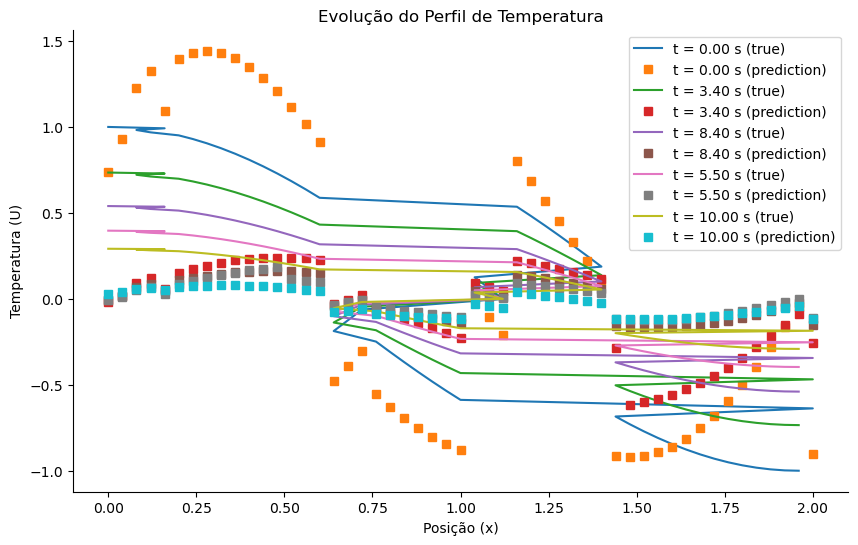

In [68]:
# Gráfico 2D: Perfis de Temperatura ao Longo do Tempo

x = x_data.numpy().reshape(-1).tolist()
x = list(set(x))

t = t_data.numpy().reshape(-1).tolist()
t = list(set(t))

Nx = len(x)
Nt = len(t)

U_sol = T_data.numpy().reshape([Nt, Nx])
U_pred = T_pred.reshape([Nt, Nx])

fig, ax = plt.subplots(figsize=(10, 6))

indices_tempo = [0, Nt // 4, Nt // 2, 3 * Nt // 4, Nt - 1]  # Pega 5 instantes de tempo
for i, t_idx in enumerate(indices_tempo):
    ax.plot(x, U_sol[t_idx, :], label=f"t = {t[t_idx]:.2f} s (true)")
    ax.plot(x, U_pred[t_idx, :], "s", label=f"t = {t[t_idx]:.2f} s (prediction)")

ax.set_title("Evolução do Perfil de Temperatura", fontsize=12)
ax.set_xlabel("Posição (x)", fontsize=10)
ax.set_ylabel("Temperatura (U)", fontsize=10)
ax.legend()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)